In [13]:
import numpy as np
import  random  
import matplotlib.pyplot as plt
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

def get_data(path,feature):
    data = load_svmlight_file(path,feature)    
    return data

# 读取数据 
data = get_data(path="a9a",feature=123)
data = get_data(path="a9a.t",feature=123)

# 数据预处理
x_train=data[0].toarray()
x_train=np.column_stack((x_train,np.ones([x_train.shape[0],1])))
y_train=data[1]
C=len(list(set(y_train)))
y_train=y_train.astype(np.int)
y_train[y_train== -1]=0
N,D  =x_train.shape

x_test=data[0].toarray()
x_test=np.column_stack((x_test,np.ones([x_test.shape[0],1])))
y_test=data[1]
y_test=y_test.astype(np.int)
y_test[y_test== -1]=0

In [14]:
# 参数初始化
maxIterations=200
eta = 1e-3  # 学习率

In [15]:
def predict(W , X, y ):
    # 所有样例的score
    score = np.dot(X,W)
    # 找到最大score
    y_pred= np.argmax(score, axis = 1)
    # 计算准确度
    cmp=(y_pred == y)
    accuracy=len(cmp[cmp==True])/len(cmp)
    
    return y_pred,accuracy 

In [16]:
def svm(W, xtrain, ytrain, xtest, ytest, reg):
    dW = np.zeros(W.shape) 
    num_classes = W.shape[1]

    #train 
    train_loss = 0
    scores_train = xtrain.dot(W)  # num_train by C
    num_train = xtrain.shape[0]
    scores_train_correct = scores_train[np.arange(num_train), ytrain]        # 1 by num_train
    scores_train_correct = np.reshape(scores_train_correct, (num_train, 1))  # num_train by 1
    margins_train = scores_train - scores_train_correct + 1.0                # num_train by C
    margins_train[np.arange(num_train), ytrain] = 0.0 
    margins_train[margins_train <= 0] = 0.0
    train_loss += np.sum(margins_train) / num_train
    train_loss += 0.5 * reg * np.sum(W * W) 
    margins_train[margins_train > 0] = 1.0                       
    row_sum = np.sum(margins_train, axis=1)                  # 1 by num_train
    margins_train[np.arange(num_train), ytrain] = -row_sum        

    gradNum =20 # 样本数量
    ind=random.sample(range(0,num_train),gradNum)  
    xtrain_batch=xtrain[ind,:]
    margins_train_batch=margins_train[ind,:]
    dW += np.dot(xtrain_batch.T, margins_train_batch)/gradNum + reg * W     # D by C
    
    #test
    test_loss = 0
    scores_test = xtest.dot(W)  # num_test by C
    num_test = xtest.shape[0]
    scores_test_correct = scores_test[np.arange(num_test), ytest]         # 1 by N
    scores_test_correct = np.reshape(scores_test_correct, (num_test, 1))  # N by 1
    margins_test = scores_test - scores_test_correct + 1.0                # N by C
    margins_test[np.arange(num_test), ytest] = 0.0 
    margins_test[margins_test <= 0] = 0.0
    test_loss += np.sum(margins_test) / num_test
    test_loss += 0.5 * reg * np.sum(W * W)

    return train_loss, test_loss, dW

In [17]:
# NAG
# 参数初始化 
W = np.zeros((D, C)) # weights
pre_d = np.zeros_like(W)
pre_grad = np.zeros_like(W)
gamma =0.9 #动量因子
L_NAG =[]; # 验证loss
for t in range(maxIterations):
    # 计算loss
    train_loss,test_loss ,grad =svm(W, x_train, y_train, x_test, y_test, reg=0.1)
    # 保存
    L_NAG.append ( test_loss)
    # 更新weights
    d  = gamma * pre_d  + grad + gamma * (grad - pre_grad)
    dW = -eta * d
    W += dW 
    pre_d = d
    pre_grad = grad
    
L_NAG=np.array(L_NAG)
# 预测结果
y_pred_NAG_train,training_accuracy_NAG = predict(W , x_train, y_train )
y_pred_NAG_test,test_accuracy_NAG = predict(W , x_test, y_test )

In [18]:
# RMSProp 
# 参数初始化  
W = np.zeros((D, C))
n = np.zeros_like(W)
gamma =0.9 # 衰退因子
epsilon = 0.001
L_RMSProp =[]  # 验证loss

for t in range(maxIterations):

    train_loss,test_loss ,grad =svm(W, x_train, y_train, x_test, y_test, reg=0.1)

    L_RMSProp.append ( test_loss)

    n = gamma * n + (1-gamma) * np.power(grad,2)
    dW = -eta /np.sqrt(n + epsilon ) * grad
    W += dW 
    
L_RMSProp=np.array(L_RMSProp)

y_pred_RMSProp_train,training_accuracy_RMSProp = predict(W , x_train, y_train )
y_pred_RMSProp_test,test_accuracy_RMSProp = predict(W , x_test, y_test )

In [19]:
# AdaDelta 
# 参数初始化
W = np.zeros((D, C))
E_g2 = np.zeros_like(W)
E_dW2 = np.zeros_like(W)
gamma =0.8
epsilon = 1e-6
L_AdaDelta =[]

for t in range(maxIterations):

    train_loss,test_loss ,grad =svm(W, x_train, y_train, x_test, y_test, reg=0.1)

    L_AdaDelta.append ( test_loss)
    
    E_g2 = gamma * E_g2 + (1-gamma) * np.power(grad,2)
    dW = - np.sqrt(E_dW2+epsilon) / np.sqrt(E_g2+epsilon) * grad    
    W += dW 
    E_dW2 = gamma * E_dW2 + (1-gamma) * np.power(dW , 2)
    
L_AdaDelta=np.array(L_AdaDelta)

y_pred_AdaDelta_train,training_accuracy_AdaDelta = predict(W , x_train, y_train )
y_pred_AdaDelta_test,test_accuracy_AdaDelta= predict(W , x_test, y_test )

In [20]:
# Adam
# 参数初始化 
W = np.zeros((D, C))
n = np.zeros_like(W)
m = np.zeros_like(W)
mu = 0.9
v = 0.9
epsilon = 1e-3
L_adam=[]

for t in range(maxIterations):

    train_loss,test_loss ,grad =svm(W, x_train, y_train, x_test, y_test, reg=0.1)
    
    L_adam.append ( test_loss)
    
    m = mu * m + (1-mu) * grad
    n = v  * n + (1-v) * np.power(grad,2)
    m_hat = m / (1-np.power(mu,t)+epsilon) 
    n_hat = n / (1-np.power(v,t)+epsilon)
    W -= m_hat * eta /(np.sqrt(n_hat) + epsilon)
    
L_adam=np.array(L_adam)

y_pred_Adam_train,training_accuracy_Adam = predict(W , x_train, y_train )
y_pred_Adam_test,test_accuracy_Adam = predict(W , x_test, y_test )

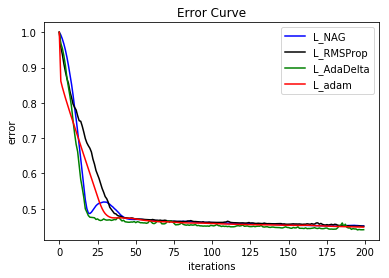

In [28]:
# 制图
plt.plot(L_NAG,'blue',label='L_NAG')
plt.plot(L_RMSProp,'black',label='L_RMSProp')
plt.plot(L_AdaDelta,'green',label='L_AdaDelta')
plt.plot(L_adam,'red',label='L_adam')
plt.title('Error Curve')
plt.xlabel('iterations')
plt.ylabel('error')
plt.legend()
plt.show()

In [23]:
# 评估和预测结果
print('training accuracy_NAG=',training_accuracy_NAG,
      '\ntraining accuracy_RMSProp=',training_accuracy_RMSProp,
      '\ntraining accuracy_AdaDelta=',training_accuracy_AdaDelta,
      '\ntraining accuracy_Adam=',training_accuracy_Adam)

print('\ntest accuracy_NAG=',test_accuracy_NAG,
      '\ntest accuracy_RMSProp=',test_accuracy_RMSProp,
      '\ntest accuracy_AdaDelta=',test_accuracy_AdaDelta,
      '\ntest accuracy_Adam=',test_accuracy_Adam)

training accuracy_NAG= 0.7640194091272035 
training accuracy_RMSProp= 0.7646336220133898 
training accuracy_AdaDelta= 0.794914317302377 
training accuracy_Adam= 0.7691787973711689

test accuracy_NAG= 0.7640194091272035 
test accuracy_RMSProp= 0.7646336220133898 
test accuracy_AdaDelta= 0.794914317302377 
test accuracy_Adam= 0.7691787973711689


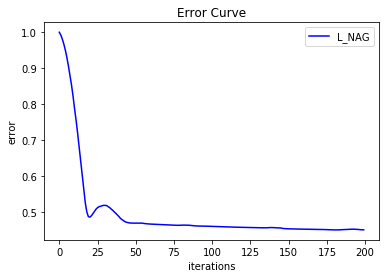

In [29]:
# NAG
plt.plot(L_NAG,'blue',label='L_NAG')

plt.title('Error Curve')
plt.xlabel('iterations')
plt.ylabel('error')
plt.legend()
plt.show()

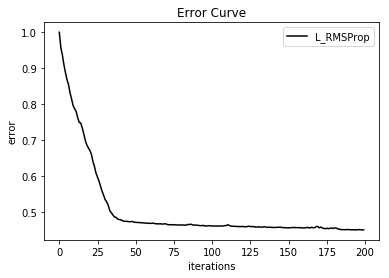

In [30]:
# RMSProp
plt.plot(L_RMSProp,'black',label='L_RMSProp')
plt.title('Error Curve')
plt.xlabel('iterations')
plt.ylabel('error')
plt.legend()
plt.show()

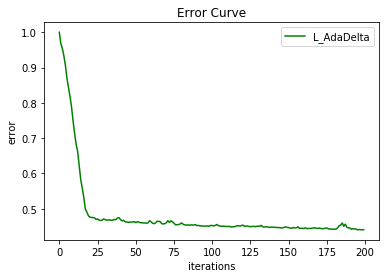

In [31]:
# AdaDelta
plt.plot(L_AdaDelta,'green',label='L_AdaDelta')

plt.title('Error Curve')
plt.xlabel('iterations')
plt.ylabel('error')
plt.legend()
plt.show()

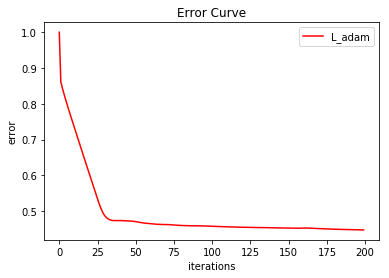

In [32]:
# adam
plt.plot(L_adam,'red',label='L_adam')

plt.title('Error Curve')
plt.xlabel('iterations')
plt.ylabel('error')
plt.legend()
plt.show()